## 1. Import Libraries

In [108]:
# for first LLM
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers.modeling_outputs import BaseModelOutput

# for second
from transformers import pipeline, T5ForConditionalGeneration, T5Tokenizer

from IPython.display import display, HTML
import torch

## 2. Choose Device (GPU / CPU)

In [109]:
# Automatically choose (prefer NVIDIA GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # OR choose device manually, be sure to comment other codes relevant to `device`
# device = torch.device("cuda")
# device = torch.device("cpu")

## 3. Load BART model and tokenizer

In [110]:
# Specify model name
model_name = "facebook/bart-base"
# model_name = "facebook/bart-large" # Recommend this one if your computer is okay with larger models

tokenizer_bart = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

## 4. A function adding AWGN noise to latent representation

In [111]:
def add_noise_with_snr(encoder_output, target_snr_db):
    """
    Add noise to the encoder output based on a target SNR in dB.
    
    Parameters:
    - encoder_output: torch.Tensor, the encoder's output (last_hidden_state).
    - target_snr_db: float, the desired signal-to-noise ratio in dB.
    
    Returns:
    - noisy_encoder_output: torch.Tensor, encoder output with added noise.
    """
    # Convert SNR from dB to linear scale
    target_snr_linear = 10 ** (target_snr_db / 10)
    
    # Calculate power of the signal
    signal_power = torch.mean(encoder_output ** 2)
    
    # Calculate required noise power for the target SNR
    noise_power = signal_power / target_snr_linear
    noise = torch.randn_like(encoder_output) * torch.sqrt(noise_power)
    
    # Add noise to the encoder output
    noisy_encoder_output = encoder_output + noise
    return noisy_encoder_output

## 5. Three example encoder inputs for `fill in the blank` task

`original_text` contains the complete text <br>
`input_text` contains the masked text

In [112]:

original_text = """
Beginners BBQ Class Taking Place in Missoula! 
Do you want to get better at making delicious BBQ?
You will have the opportunity, put this on your calendar now. 
Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. 
He will be teaching a beginner level class for everyone who wants to get better with their culinary skills. 
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information. 
The cost to be in the class is $35 per person, and for spectators it is free. 
Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.
""".replace("\n", "")

input_text = """
Beginners BBQ Class <mask> in Missoula! 
Do you want to <mask> making delicious BBQ?
You will have the opportunity, put this on your calendar now. 
Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. 
He will be teaching a beginner level class for everyone who wants to get better with their culinary skills. 
He will teach you <mask> compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information. 
The <mask> the class is $35 per person, and for spectators it is free. 
Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.
""".replace("\n", "")


# original_text = """
# This November, embark on an exciting hiking adventure! 
# Explore the scenic mountain trails with an experienced guide, who will show you the best routes and hidden viewpoints. 
# This journey is suitable for all levels, from beginners to advanced hikers. 
# The hike covers approximately 10 miles and includes multiple rest stops with breathtaking views. 
# Participants should bring water, snacks, and comfortable hiking shoes. 
# The cost of the trip is $60, which includes a map and a group photo.
# """
# input_text = """
# This November, embark on an exciting <mask> adventure! 
# Explore the scenic mountain trails with an experienced guide, who will show you the best routes and hidden <mask>. 
# This journey is suitable for all levels, from beginners to advanced <mask>. 
# The hike covers approximately 10 miles and includes multiple rest stops with breathtaking <mask>. 
# Participants should bring water, snacks, and comfortable hiking shoes. 
# The <mask> is $60, which includes a map and a group photo.
# """.replace("\n", "")

# original_text = """
# Welcome to our online coding bootcamp program! 
# Whether you're a complete beginner or looking to improve your programming skills, this course is designed for you. 
# Throughout the course, you will learn essential coding languages such as Python and JavaScript. 
# Our instructors will guide you through interactive projects and provide real-time feedback. 
# Each student will receive a certificate of completion at the end of the program. 
# The total cost for the bootcamp is $150, which includes all learning materials.
# """
# input_text = """
# Welcome to our online <mask> bootcamp program! 
# Whether you're a complete beginner or looking to <mask> your programming skills, this course is designed for you. 
# Throughout the course, you will learn essential <mask> such as Python and JavaScript. 
# Our instructors will guide you through interactive projects and provide real-time <mask>. 
# Each student will receive a certificate of completion at the end of the <mask>. 
# The total cost for the bootcamp is $150, which <mask> all learning materials.
# """.replace("\n", "")

print(input_text)

Beginners BBQ Class <mask> in Missoula! Do you want to <mask> making delicious BBQ?You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills. He will teach you <mask> compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information. The <mask> the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.


## 6. Pass the `input_text` through the LLM

### 6.1 Tokenize the `input_text` to tokens (integer numbers)

In [113]:
input_ids = tokenizer_bart(input_text, return_tensors="pt").input_ids.to(device)

### 6.2 Get encoder output

In [114]:
with torch.no_grad():
    encoder_outputs = model.model.encoder(input_ids=input_ids)

### 6.3.1 Case 1: clean latent reprenstation (without noise)

In [115]:
# Generate output with the clean encoder output (latent reprenstation)
baseline_outputs = model.generate(
    input_ids=None,                   # No input tokens are provided here, as we're feeding encoder outputs directly
    encoder_outputs=encoder_outputs,  # Encoded representations from the encoder
    max_length=200,                   # Set maximum length for the generated text sequence
    min_length=50,                    # Set minimum length for the generated text sequence
    do_sample=True,                   # Enables sampling for diverse outputs, rather than greedy decoding
    temperature=0.1,                   # Low temperature to control randomness, resulting in less varied output
)

# Decode the decoder output using tokenizer
baseline_text = tokenizer_bart.decode(baseline_outputs[0], skip_special_tokens=True)

### 6.3.2 Case 2: noisy latent reprenstation

In [116]:
# Add noise with a target SNR and generate noisy output (latent reprenstation)
target_snr = 3  # Set target SNR
noisy_encoder_output = add_noise_with_snr(encoder_outputs.last_hidden_state, target_snr) # Add noise
modified_encoder_outputs = BaseModelOutput(last_hidden_state=noisy_encoder_output) # There are slight differences between `noisy_encoder_output` and `modified_encoder_outputs`, print them for more info

# Generate output with the noisy encoder output
noisy_outputs = model.generate(
    input_ids=None,                            # No input tokens are provided here, as we're feeding encoder outputs directly
    encoder_outputs=modified_encoder_outputs,  # Encoded representations from the encoder
    max_length=200,                            # Set maximum length for the generated text sequence
    min_length=50,                             # Set minimum length for the generated text sequence
    do_sample=True,                            # Enables sampling for diverse outputs, rather than greedy decoding
    temperature=0.1                            # Low temperature to control randomness, resulting in less varied output
)


# Decode the decoder output using tokenizer
noisy_text = tokenizer_bart.decode(noisy_outputs[0], skip_special_tokens=True)

## 7. Display original texts and both outputs 

In [117]:
print('Original Text:')
display(HTML(f"<p style='font-size:15px; font-family:\"Comic Sans MS\", cursive;'> {original_text}</p>"))
print('\n')

print('Without Noise:')
display(HTML(f"<p style='font-size:15px; font-family:\"Comic Sans MS\", cursive;'>{baseline_text}</p>"))
print('\n')

print(f'With Noise (SNR = {target_snr} dB):')
display(HTML(f"<p style='font-size:15px; font-family:\"Comic Sans MS\", cursive;'>{noisy_text}</p>"))
print('\n')

Original Text:




Without Noise:




With Noise (SNR = 3 dB):


## 8. Load FalconsAI Summarizer and Tokenizer

In [118]:
# Specify model name
summarizer_name = "Falconsai/text_summarization"

tokenizer_sum = T5Tokenizer.from_pretrained(summarizer_name)
summarizer = T5ForConditionalGeneration.from_pretrained(summarizer_name).to(device)

## 9. Pass the generated texts through the Summarizer

### 9.1 Tokenize the generated texts to tokens (integer numbers)

In [123]:
noisy_text = "Beginners BBQ Class is now available for the first time in Missoula! Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join L’s new Chef, Tony Balay from Lonestar BBQ Champion. He will be teaching a beginner level class for everyone who wants to get a beginner to learn how to cook and cook. He will be giving you all the information that will help you compete in a KCBS BBQ competition, including techniques, techniques, timelines, meat selection and trimming, plus smoker and fire information. The cost of the class is $35 per per person, for for the class, it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared. You will also be able to get samples from the different meats that are prepared."

In [ ]:
original_ids = tokenizer_sum('Summarize' + original_text, return_tensors="pt").input_ids.to(device)
baseline_ids = tokenizer_sum('Summarize' + baseline_text, return_tensors="pt").input_ids.to(device)
noisy_ids = tokenizer_sum('Summarize' + noisy_text, return_tensors="pt").input_ids.to(device)

### 9.2 Get encoder output

In [125]:
with torch.no_grad():
    original_encoder_outputs = summarizer.encoder(input_ids=original_ids)
    baseline_encoder_outputs = summarizer.encoder(input_ids=baseline_ids)
    noisy_encoder_outputs = summarizer.encoder(input_ids=noisy_ids)
    

### 9.3 Representations

In [126]:
original_sum_output = summarizer.generate(
    input_ids=None,
    encoder_outputs=original_encoder_outputs,
    output_hidden_states=True,
    return_dict_in_generate=True,
    max_length=70,
    do_sample=True,
    temperature=0.1
)
original_summary = tokenizer_sum.decode(original_sum_output.sequences[0], skip_special_tokens=True)

baseline_sum_output = summarizer.generate(
    input_ids=None,
    encoder_outputs=baseline_encoder_outputs,
    output_hidden_states=True,
    return_dict_in_generate=True,
    max_length=70,
    do_sample=True,
    temperature=0.1
)
baseline_summary = tokenizer_sum.decode(baseline_sum_output.sequences[0], skip_special_tokens=True)


noisy_sum_output = summarizer.generate(
    input_ids=None,
    encoder_outputs=noisy_encoder_outputs,
    output_hidden_states=True,
    return_dict_in_generate=True,
    max_length=70,
    do_sample=True,
    temperature=0.1
)
noisy_summary = tokenizer_sum.decode(noisy_sum_output.sequences[0], skip_special_tokens=True)


## 10. Display all summaries

In [127]:
print('Original Summary:')
display(HTML(f"<p style='font-size:15px; font-family:\"Comic Sans MS\", cursive;'> {original_summary}</p>"))
print('\n')


print('Without Noise:')
display(HTML(f"<p style='font-size:15px; font-family:\"Comic Sans MS\", cursive;'>{baseline_summary}</p>"))
print('\n')

print(f'With Noise (SNR = {target_snr} dB):')
display(HTML(f"<p style='font-size:15px; font-family:\"Comic Sans MS\", cursive;'>{noisy_summary}</p>"))
print('\n')


Original Summary:




Without Noise:




With Noise (SNR = 3 dB):


## 11. Get Embeddings of summaries

In [16]:
def extract_hidden_states(decoder_hidden_states: tuple):
    """
    Extract the hidden states of last layer in decoder block
    """
    last_column = [row[-1] for row in decoder_hidden_states]
    last_layer_hs = torch.stack(last_column).squeeze()  

    return last_layer_hs

In [17]:
em_original_summary = extract_hidden_states(original_sum_output.decoder_hidden_states)
em_baseline_summary = extract_hidden_states(baseline_sum_output.decoder_hidden_states)
em_noisy_summary = extract_hidden_states(noisy_sum_output.decoder_hidden_states)

## 12. Pad embeddings

In [18]:
def align_tensors(tensor_a, tensor_b):
    """
    Aligns two tensors along the first dimension by padding.

    Args:
        tensor_a (torch.Tensor): The first tensor.
        tensor_b (torch.Tensor): The second tensor.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: The two tensors aligned along the first dimension.
    """
    # Get the first dimension sizes
    m, n = tensor_a.size(0), tensor_b.size(0)
    # Pad to the maximum length along the first dimension
    max_rows = max(m, n)
    if m < max_rows:
        padding = torch.zeros((max_rows - m, *tensor_a.shape[1:]), device=tensor_a.device)
        tensor_a = torch.cat([tensor_a, padding], dim=0)
    if n < max_rows:
        padding = torch.zeros((max_rows - n, *tensor_b.shape[1:]), device=tensor_b.device)
        tensor_b = torch.cat([tensor_b, padding], dim=0)

    return tensor_a, tensor_b


## 13. Metrics to compare embeddings

### 13.1 Cosine Similarity

In [19]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [21]:
# Compute Cosine Similarities
pad_em_baseline_summary, pad_em_original_summary = align_tensors(em_baseline_summary, em_original_summary)
cs_base_orig = F.cosine_similarity(pad_em_baseline_summary, pad_em_original_summary, dim=1).mean().item()
pad_em_baseline_summary, pad_em_noisy_summary = align_tensors(em_baseline_summary, em_noisy_summary)
cs_base_noisy = F.cosine_similarity(pad_em_baseline_summary, pad_em_noisy_summary, dim=1).mean().item()

print(f"Cosine Similarity of the baseline summary to the original summary is: {cs_base_orig:.3f}")
print(f"Cosine Similarity of the baseline summary to the noisy summary is: {cs_base_noisy:.3f}")

Cosine Similarity of the baseline summary to the original summary is: 0.870
Cosine Similarity of the baseline summary to the noisy summary is: 0.866


### 13.2 Mutual Information

In [77]:
# using NPEET (referenced in MI paper) to calculate MI
import entropy_estimators as ee
import numpy as np

In [78]:
#This function is taken from the github of mutual information paper

def ksg(x, y, k=3):
    """
    Kraskov–Stogbauer–Grassberger (KSG) estimator of mutual information between two sentences represented as word embedding matrices x and y
    :param x: list of word embeddings for the first sentence
    :param y: list of word embeddings for the second sentence
    :return: KSG similarity measure between the two sentences
    """

    return ee.mi(x.T, y.T,k=3, base=np.e)

In [79]:
# Compute Mutual Information
# Move the tensor to CPU first, then convert to NumPy
em_original_summary_np = em_original_summary.cpu().numpy()
em_baseline_summary_np = em_baseline_summary.cpu().numpy()
em_noisy_summary_np = em_noisy_summary.cpu().numpy()

mi_base_orig = ksg(em_baseline_summary_np, em_original_summary_np)
mi_base_noisy = ksg(em_baseline_summary_np, em_noisy_summary_np)

print(f"Mutual Information of the baseline summary to the original summary is: {mi_base_orig:.3f}")
print(f"Mutual Information of the baseline summary to the noisy summary is: {mi_base_noisy:.3f}")

Mutual Information of the baseline summary to the original summary is: 4.013
Mutual Information of the baseline summary to the noisy summary is: 4.651


## For different SNRs

In [ ]:
# Define SNR range
snr_range = list(range(-20, 21, 4)) + list(range(22, 55, 5)) + list(range(64, 101, 6))  # From -20 to 100, with different resolution
cs_list = []
mi_list = []

# 6.1
input_ids = tokenizer_bart(input_text, return_tensors="pt").input_ids.to(device)
# 6.2
with torch.no_grad():
    encoder_outputs = model.model.encoder(input_ids=input_ids)
# 6.3.1 (no noise)
baseline_outputs = model.generate(input_ids=None, encoder_outputs=encoder_outputs, max_length=200, min_length=50, do_sample=True,
                                  temperature=0.1)
baseline_text = tokenizer_bart.decode(baseline_outputs[0], skip_special_tokens=True)

# 9.1
original_ids = tokenizer_sum('Summarize' + original_text, return_tensors="pt").input_ids.to(device)
baseline_ids = tokenizer_sum('Summarize' + baseline_text, return_tensors="pt").input_ids.to(device)

# 9.2
with torch.no_grad():
    original_encoder_outputs = summarizer.encoder(input_ids=original_ids)
    baseline_encoder_outputs = summarizer.encoder(input_ids=baseline_ids)

# 9.3
original_sum_output = summarizer.generate(input_ids=None, encoder_outputs=original_encoder_outputs, max_length=70, output_hidden_states=True,
                                          return_dict_in_generate=True, do_sample=True, temperature=0.1)
original_summary = tokenizer_sum.decode(original_sum_output.sequences[0], skip_special_tokens=True)

baseline_sum_output = summarizer.generate(input_ids=None, encoder_outputs=baseline_encoder_outputs, max_length=70, output_hidden_states=True,
                                          return_dict_in_generate=True, do_sample=True, temperature=0.1)
baseline_summary = tokenizer_sum.decode(baseline_sum_output.sequences[0], skip_special_tokens=True)

# 11
em_original_summary = extract_hidden_states(original_sum_output.decoder_hidden_states)
em_baseline_summary = extract_hidden_states(baseline_sum_output.decoder_hidden_states)

# 13.1
pad_em_baseline_summary, pad_em_original_summary = align_tensors(em_baseline_summary, em_original_summary)
cs_base_orig = F.cosine_similarity(pad_em_baseline_summary, pad_em_original_summary, dim=1).mean().item()

# 13.2
em_original_summary_np = em_original_summary.cpu().numpy()
em_baseline_summary_np = em_baseline_summary.cpu().numpy()

mi_base_orig = ksg(em_baseline_summary_np, em_original_summary_np)



# Iterate over SNR values and calculate CS and MI for each summary pair
for target_snr in snr_range:
    # 6.3.2 (with noise)
    noisy_encoder_output = add_noise_with_snr(encoder_outputs.last_hidden_state, target_snr)
    modified_encoder_outputs = BaseModelOutput(last_hidden_state=noisy_encoder_output)
    # I set min_length to 50, otherwise output for very noisy cases too short for summarizer
    noisy_outputs = model.generate(input_ids=None, encoder_outputs=modified_encoder_outputs, max_length=200, min_length=50, do_sample=True, 
                                   temperature=0.1)
    noisy_text = tokenizer_bart.decode(noisy_outputs[0], skip_special_tokens=True)
    
    # 9.1
    noisy_ids = tokenizer_sum('Summarize' + noisy_text, return_tensors="pt").input_ids.to(device)

    # 9.2
    with torch.no_grad():
        noisy_encoder_outputs = summarizer.encoder(input_ids=noisy_ids)
    
    # 9.3
    noisy_sum_output = summarizer.generate(input_ids=None, encoder_outputs=noisy_encoder_outputs, max_length=70, output_hidden_states=True,
                                           return_dict_in_generate=True, do_sample=True, temperature=0.1)
    noisy_summary = tokenizer_sum.decode(noisy_sum_output.sequences[0], skip_special_tokens=True)
    print(noisy_summary)
    
    
    # 11
    em_noisy_summary = extract_hidden_states(noisy_sum_output.decoder_hidden_states)
    
    # 13.1
    pad_em_baseline_summary, pad_em_noisy_summary = align_tensors(em_baseline_summary, em_noisy_summary)
    cs_list.append(F.cosine_similarity(pad_em_baseline_summary, pad_em_noisy_summary, dim=1).mean().item())
    
    # 13.2
    em_noisy_summary_np = em_noisy_summary.cpu().numpy()
    mi_list.append(ksg(em_baseline_summary_np, em_noisy_summary_np))
    
    
    print(target_snr)
    

advertisement ( @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @
-20
( ( ( ( ( ( ( ( ( ()) - unilaterally and -- new of, ( ( ( ( ( ( ()) and ( ( ( ( ( ( ( ( ())) ( ( ( ( ( ( ( ())) ( ( ( ( ( ( ( ())) ( ( ( (
-16
/ -,- ( ( ('(. crazy'( and'''' ( '. crazy'( and'''' (''....- '.-,''' '' '.
-12
-- to Korean-- and- who-- with to- to-,-- (- of, will--- of or L of still of to of-J, or or year- to/--, year, of; Indonesian, all. year still or even or even or of even or even or
-8
I,-I-A-I,I-C-G-IIA.-I.G.I.I-B, and I 04-I Miami, and I,-I-I-I-I-I-I-I-I-I-I-I-I-I-
-4
and your personal. Your private. Your private. This will all private. You will also, and view, private. And, and still, and will, and will. This private and will. and will. Your competitors and your competitors and your competitors and your private,and will. Your competitors and your competitors and your private,and
0
BBQ Class at the K-12 school in the school's

In [81]:
print(original_summary)
print(baseline_summary)

BBQ Class Taking Place in Missoula! The cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.
BBQ Class at Lonestar Smoke Rangers in Missoula! The cost of the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.


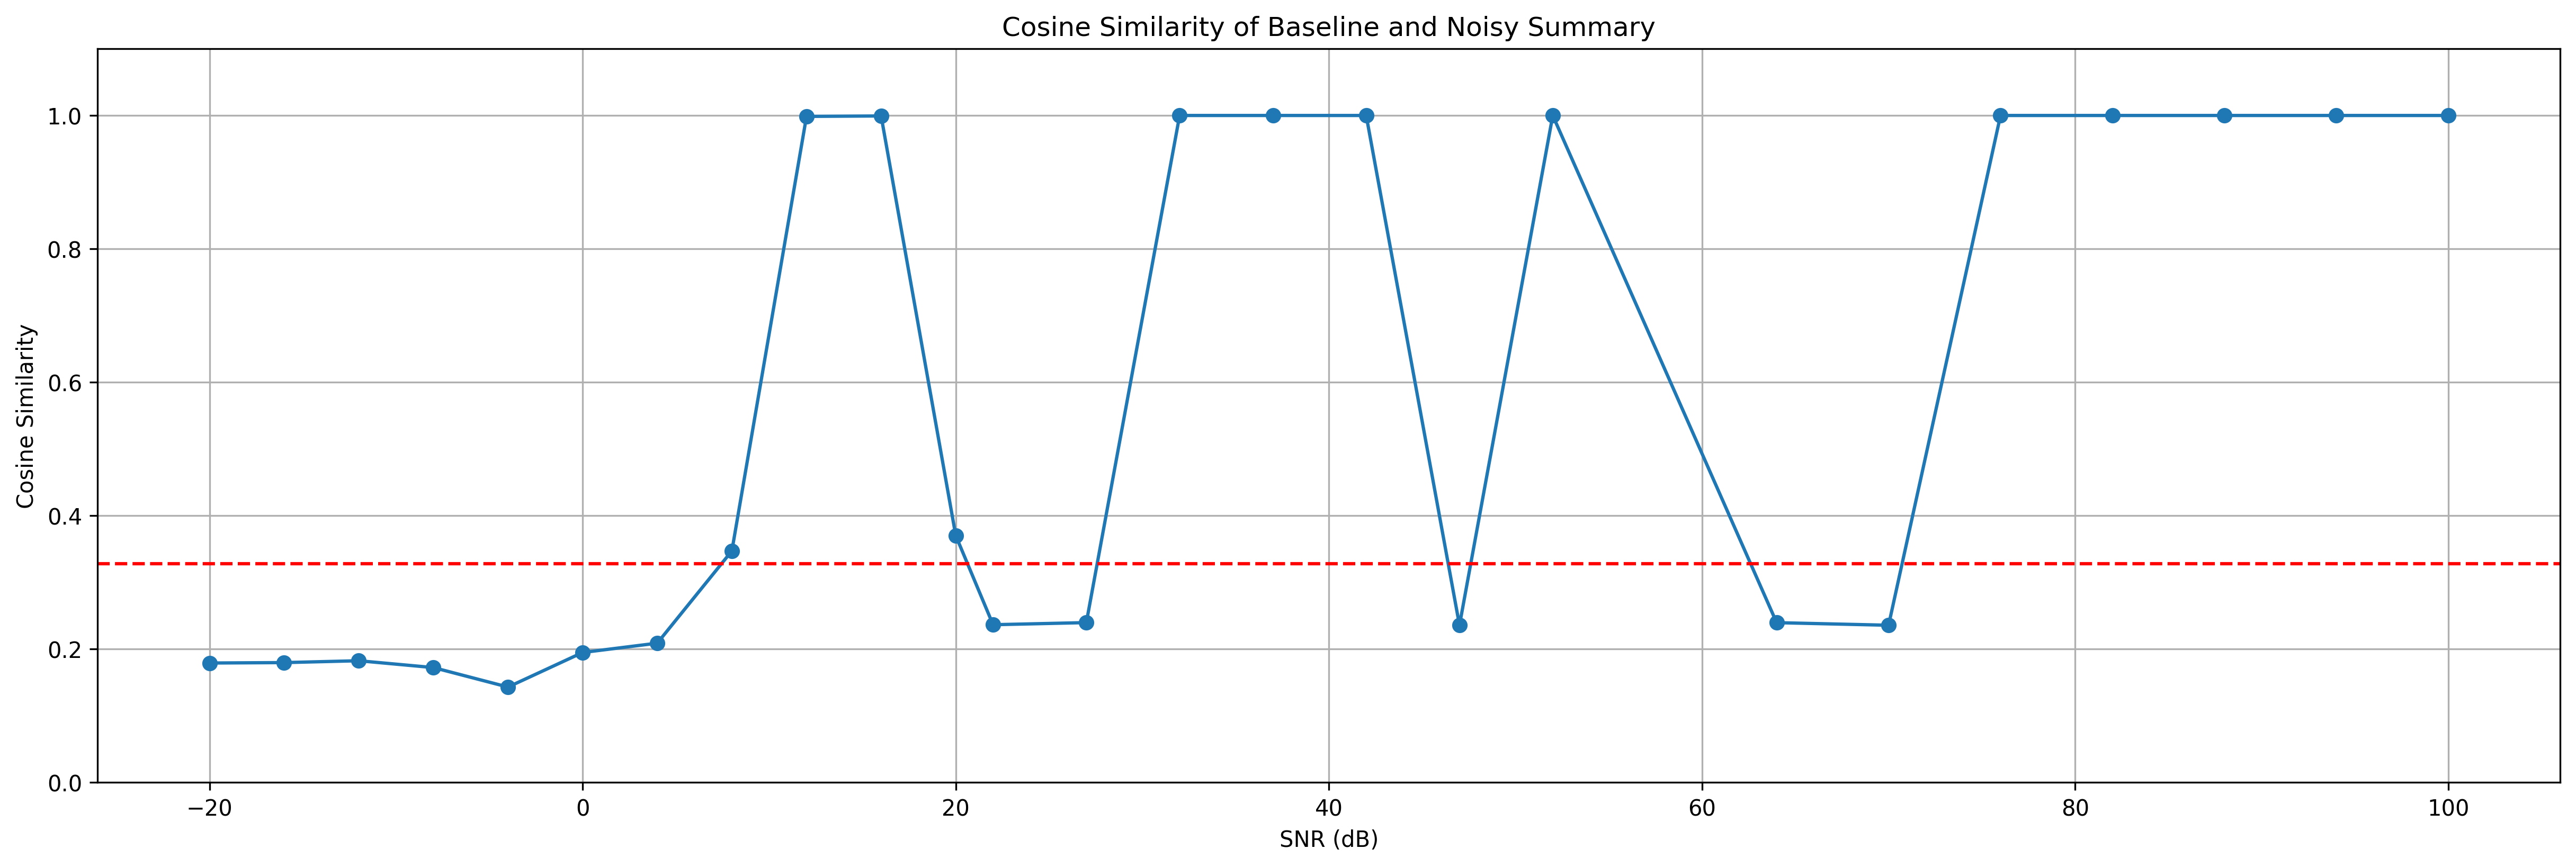

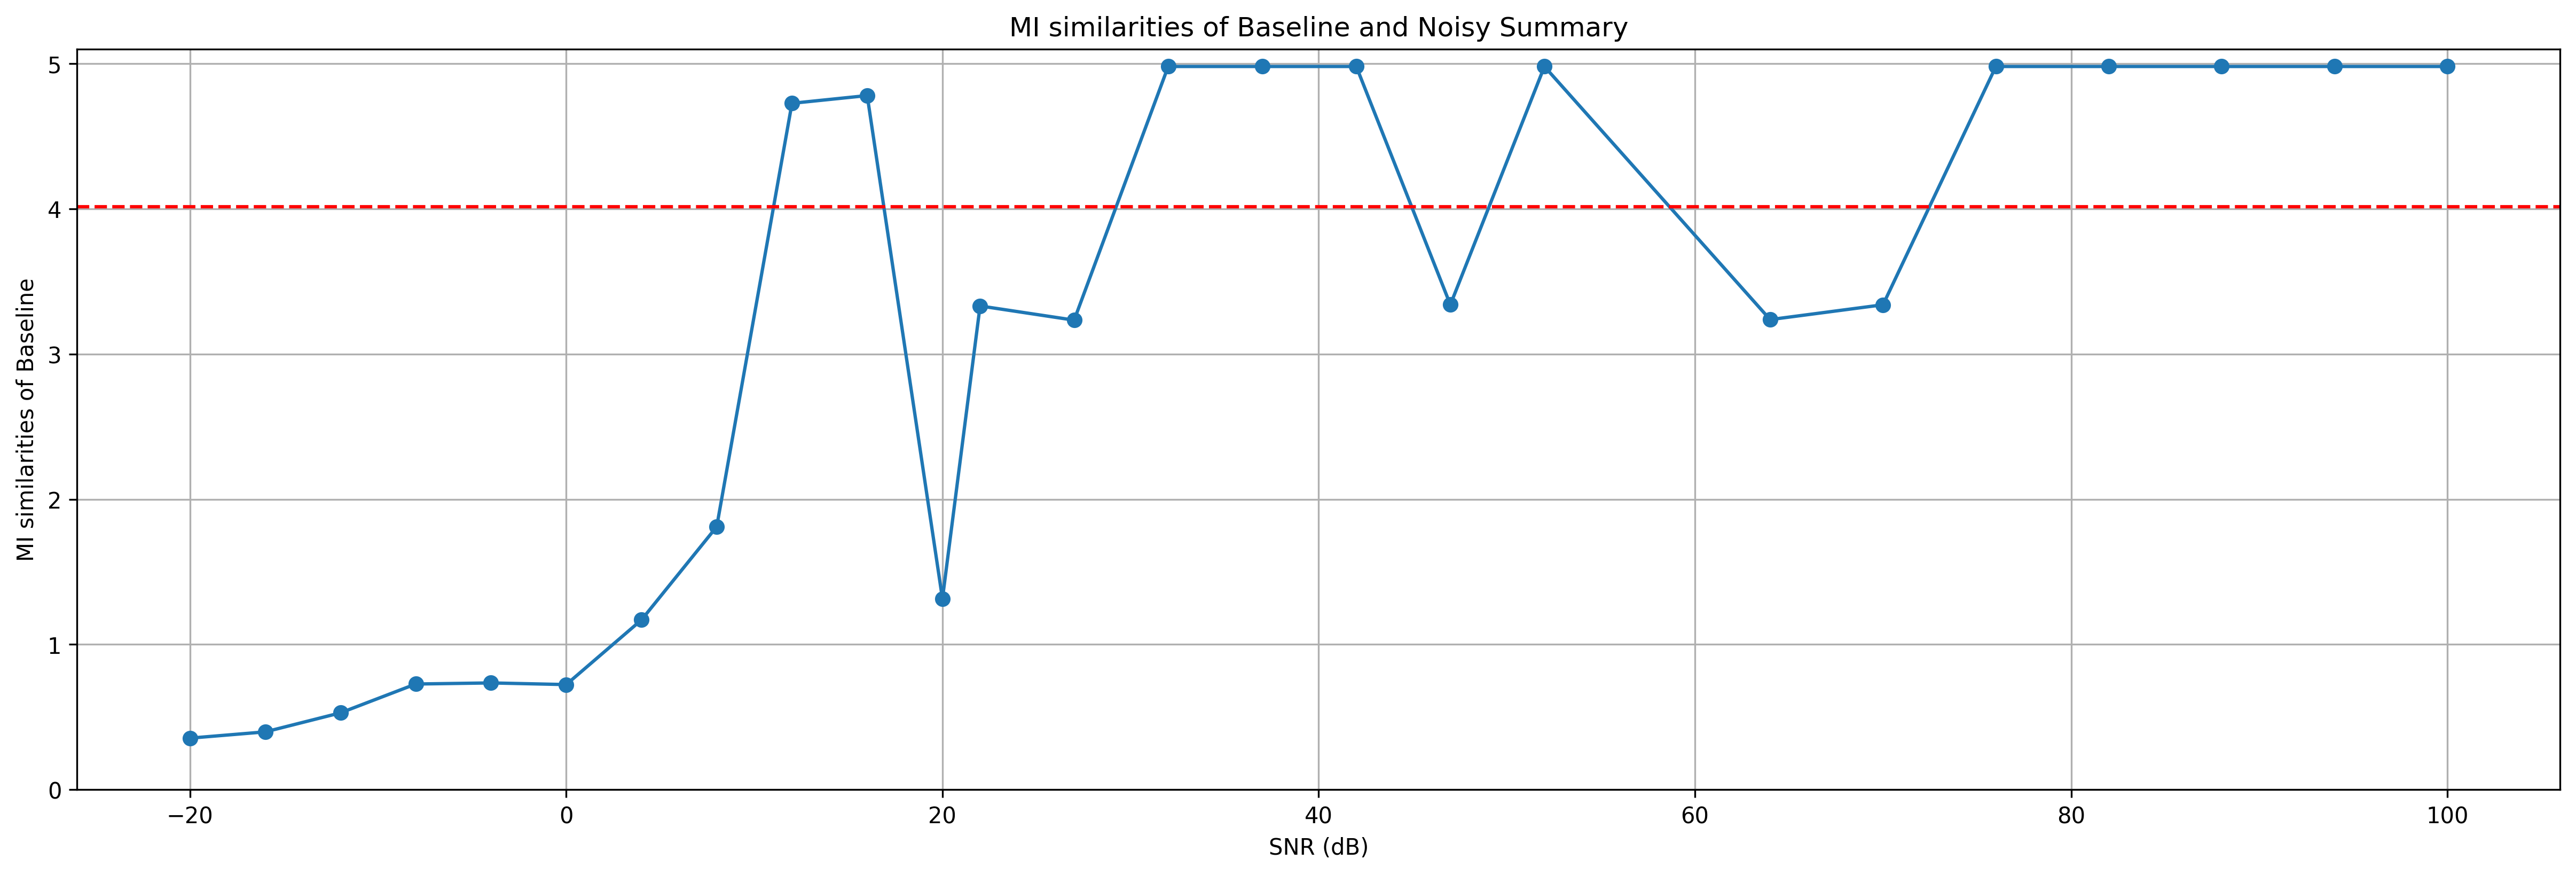

In [84]:
plt.figure(figsize=(20, 6), dpi=300)
plt.plot(snr_range, cs_list, marker='o')
plt.axhline(y=cs_base_orig, color='r', linestyle='--', label='Cosine Similarity between the baseline and the original')
plt.ylim([0.0,1.1])
plt.xlabel("SNR (dB)")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of Baseline and Noisy Summary")
plt.grid()
plt.show()

plt.figure(figsize=(20, 6), dpi=300)
plt.plot(snr_range, mi_list, marker='o')
plt.axhline(y=mi_base_orig, color='r', linestyle='--', label='Mutual Information between the baseline and the original')
plt.ylim([0.0,5.1])
plt.xlabel("SNR (dB)")
plt.ylabel("MI similarities of Baseline")
plt.title("MI similarities of Baseline and Noisy Summary")
plt.grid()
plt.show()
